Profile plot description:
The figure was generated using the profile plot utility of deeptools. Both sample show a peak in ChIP signal and an immediate drop off at the TSS and low signal all the way until the TES as expected. This shows open chromatin at the TSS as expected for conditions with high TF activity

Methods:
Obtained reads were first put through QC analysis with FastQC. After inspecting QC metrics, reads were then trimmed using Trimmomatic before alignment with Bowtie2 to an index built from the human reference genome (GRCh38), also using Bowtie2. Reads were then sorted and indexed with samtools before samtools flagstat was used to generate metrics for alignment. At this point QC reports and log files were compiled using MultiQC. BigWig files were then generated using deeptools bamCoverage utility, with coverage summarized using deeptools bamCoverage and corrPlot utilities. Peakcalling with MACS3 was then performed on the sorted BAM files. The bedtools intersect utility was then used to generate a set of reproducible peaks by identifying peaks from both replicates that overlapped by 50% reciprocally befor again using bedtools intersect to filter out peaks overlapping blacklisted regions. Peak annotation was done using HOMER with default parameters. Bedtools computeMatrix and plotProfile utilities were then used to generate a profile plot from BigWig files. Lastly, the HOMER findMotifsGenome.pl script was used to find motifs in the filtered peaks. 

QC Report Summary:
Firstly, looking at the FastQC reports, GC content appears to follow a roughly normal distribution but differs slightly between INPUT and IP samples, as well as having what looks to be a small second peak in all distributions. Given that we expect different sequences between IP and INPUT, this isn't a red flag. However, FastQC does consider the distributions for the INNPUT samples to show an issue, which may need to be investigated further. Quality scores also look fine, with high quality across all samples. Duplication is higher in IP samples but again that is to be expected. One concern is the much lower number of sequences in the rep2 INPUT, with 10M instead of the ~30M in other samples. Flagstat results don't seem to show red flags either, with most reads from all samples passing QC checks and mapping. Trimmomatic also shows not many sequences were dropped, which is a good sign. 

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import re


In [3]:
# read in peaks
peaks = pd.read_table("results/annotated_peaks.txt")

# set colnames for readability
peaks.columns = ['id', 'chrom', 'start', 'end', 'strand', 'score', 'focus', 'annotation', 'details', 'dist', 'promID', 'entrez', 'unigene', 'refseq', 'ensembl', 'gene_name', 'alias', 'desc', 'type']
peaks.head(10)

,id,chrom,start,end,strand,score,focus,annotation,details,dist,promID,entrez,unigene,refseq,ensembl,gene_name,alias,desc,type
0,rep2_peak_6157,chr16,11915871,11916320,+,3918,NaN,promoter-TSS (ENST00000420576.6),protein_coding-promoter-TSS (ENST00000420576.6),-13.0,ENST00000420576.6,ENSG00000103342,ENST00000563468,NaN,NaN,GSPT1,NaN,NaN,protein_coding
1,rep2_peak_1156,chr1,148679420,148680085,+,3495,NaN,promoter-TSS (ENST00000593495.4),protein_coding-promoter-TSS (ENST00000593495.4),-6.0,ENST00000593495.4,ENSG00000286019,ENST00000593495,NaN,NaN,NOTCH2NLB,NaN,NaN,protein_coding
2,rep2_peak_8833,chr2,11498541,11498959,+,3289,NaN,"intron (ENST00000628795.2, intron 1 of 2)","protein_coding-intron (ENST00000628795.2, intr...",16409.0,ENST00000628795.2,ENSG00000196208,ENST00000628795,NaN,NaN,GREB1,NaN,NaN,protein_coding
3,rep2_peak_1667,chr1,205211237,205211902,+,3031,NaN,promoter-TSS (ENST00000367161.7),protein_coding-promoter-TSS (ENST00000367161.7),-3.0,ENST00000367161.7,ENSG00000133059,ENST00000367162,NaN,NaN,DSTYK,NaN,NaN,protein_coding
4,rep2_peak_1176,chr1,149390252,149390810,+,3027,NaN,promoter-TSS (ENST00000621744.4),protein_coding-promoter-TSS (ENST00000621744.4),-90.0,ENST00000650865.2,ENSG00000286219,ENST00000578189,NaN,NaN,NOTCH2NLC,NaN,NaN,protein_coding
5,rep2_peak_959,chr1,120069168,120070018,+,2780,NaN,promoter-TSS (ENST00000256646.7),protein_coding-promoter-TSS (ENST00000256646.7),23.0,ENST00000652302.1,ENSG00000134250,ENST00000650638,NaN,NaN,NOTCH2,NaN,NaN,protein_coding
6,rep2_peak_5368,chr15,50354820,50355604,+,2767,NaN,promoter-TSS (ENST00000220429.12),protein_coding-promoter-TSS (ENST00000220429.12),7.0,ENST00000667317.3,ENSG00000244879,ENST00000648591,NaN,NaN,GABPB1-AS1,NaN,NaN,lncRNA
7,rep2_peak_1106,chr1,146228817,146229332,+,2704,NaN,promoter-TSS (ENST00000362074.8),protein_coding-promoter-TSS (ENST00000362074.8),-33.0,ENST00000689750.1,ENSG00000264343,ENST00000686973,NaN,NaN,NOTCH2NLA,NaN,NaN,protein_coding
8,rep2_peak_16580,chr8,144078309,144078748,+,2450,NaN,promoter-TSS (ENST00000316052.6),protein_coding-promoter-TSS (ENST00000316052.6),-114.0,ENST00000703646.1,ENSG00000290230,ENST00000703646,NaN,NaN,ENSG00000290230,NaN,NaN,protein_coding
9,rep2_peak_16254,chr8,102600709,102601520,+,2428,NaN,Intergenic,Intergenic,21217.0,ENST00000521750.3,ENSG00000253382,ENST00000521750,NaN,NaN,POU5F1P2,NaN,NaN,processed_pseudogene


In [4]:
# read in rnaseq res
rnaseq = pd.read_table("rnaseq_res.txt")

# filter by padj
pcut = 0.05
rnaseq_fltr = rnaseq[rnaseq['padj'] < 0.05]
rnaseq_fltr.columns = ['gene_name', 'transcript', 'log2FoldChange', 'padj']
rnaseq_fltr.head()

,gene_name,transcript,log2FoldChange,padj
7,RAD9A,"NM_001243224,NM_004584",-0.994436,4.514560e-06
8,TMEM70,"NM_001040613,NM_017866,NR_033334",-0.655475,1.825129e-03
12,FAM133B,"NM_001040057,NM_001288584,NM_152789,NR_109929",-0.521628,3.368896e-02
14,LRRC20,"NM_001278211,NM_001278212,NM_001278213,NM_0012...",0.646662,1.476895e-02
22,SLC7A5,NM_003486,-0.785875,7.129022e-09


In [5]:
merged = pd.merge(rnaseq_fltr, peaks, on='gene_name')
merged.head()

,gene_name,transcript,log2FoldChange,padj,id,chrom,start,end,strand,score,...,details,dist,promID,entrez,unigene,refseq,ensembl,alias,desc,type
0,RAD9A,"NM_001243224,NM_004584",-0.994436,4.514560e-06,rep2_peak_3056,chr11,67317674,67317861,+,232,...,protein_coding-promoter-TSS (ENST00000622583.4),-104.0,ENST00000622583.4,ENSG00000172613,ENST00000541132,NaN,NaN,NaN,NaN,protein_coding
1,FAM133B,"NM_001040057,NM_001288584,NM_152789,NR_109929",-0.521628,3.368896e-02,rep2_peak_15299,chr7,92590207,92590477,+,120,...,protein_coding-promoter-TSS (ENST00000415397.6),-4.0,ENST00000480397.5,ENSG00000234545,ENST00000427372,NaN,NaN,NaN,NaN,protein_coding
2,SLC7A5,NM_003486,-0.785875,7.129022e-09,rep2_peak_6786,chr16,87853607,87853909,+,33,...,"protein_coding-intron (ENST00000261622.5, intr...",9881.0,ENST00000565644.5,ENSG00000103257,ENST00000261622,NaN,NaN,NaN,NaN,protein_coding
3,RPS3A,"NM_001006,NM_001267699",0.514167,3.873625e-05,rep2_peak_13060,chr4,151099373,151099653,+,331,...,protein_coding-promoter-TSS (ENST00000274065.9),-111.0,ENST00000509736.5,ENSG00000145425,ENST00000510993,NaN,NaN,NaN,NaN,protein_coding
4,KIF13B,NM_015254,0.956301,5.970709e-06,rep2_peak_15892,chr8,29286817,29287171,+,262,...,Intergenic,-23870.0,ENST00000522355.5,ENSG00000197892,ENST00000523130,NaN,NaN,NaN,NaN,protein_coding


In [6]:
# read in motif finding
motifs = pd.read_table("results/homermotifs/knownResults.txt")
motifs.head(20)

,Motif Name,Consensus,P-value,Log P-value,q-value (Benjamini),# of Target Sequences with Motif(of 3060),% of Target Sequences with Motif,# of Background Sequences with Motif(of 43416),% of Background Sequences with Motif
0,RUNX(Runt)/HPC7-Runx1-ChIP-Seq(GSE22178)/Homer,SAAACCACAG,0.000000e+00,-994.8,0.0,929.0,30.36%,2231.6,5.14%
1,RUNX1(Runt)/Jurkat-RUNX1-ChIP-Seq(GSE29180)/Homer,AAACCACARM,1.000000e-311,-717.1,0.0,935.0,30.56%,3215.6,7.41%
2,RUNX2(Runt)/PCa-RUNX2-ChIP-Seq(GSE33889)/Homer,NWAACCACADNN,1.000000e-214,-494.8,0.0,714.0,23.33%,2605.0,6.01%
3,RUNX-AML(Runt)/CD4+-PolII-ChIP-Seq(Barski_et_a...,GCTGTGGTTW,1.000000e-206,-476.3,0.0,663.0,21.67%,2326.1,5.36%
4,Foxa2(Forkhead)/Liver-Foxa2-ChIP-Seq(GSE25694)...,CYTGTTTACWYW,1.000000e-89,-205.1,0.0,379.0,12.39%,1622.6,3.74%
5,FOXA1(Forkhead)/LNCAP-FOXA1-ChIP-Seq(GSE27824)...,WAAGTAAACA,1.000000e-85,-196.0,0.0,469.0,15.33%,2413.9,5.57%
6,FOXA1(Forkhead)/MCF7-FOXA1-ChIP-Seq(GSE26831)/...,WAAGTAAACA,1.000000e-85,-195.9,0.0,413.0,13.50%,1947.8,4.49%
7,GRHL2(CP2)/HBE-GRHL2-ChIP-Seq(GSE46194)/Homer,AAACYKGTTWDACMRGTTTB,1.000000e-83,-192.0,0.0,266.0,8.69%,887.5,2.05%
8,Fosl2(bZIP)/3T3L1-Fosl2-ChIP-Seq(GSE56872)/Homer,NATGASTCABNN,1.000000e-77,-179.0,0.0,241.0,7.88%,781.3,1.80%
9,Fra2(bZIP)/Striatum-Fra2-ChIP-Seq(GSE43429)/Homer,GGATGACTCATC,1.000000e-77,-178.7,0.0,283.0,9.25%,1063.2,2.45%


/scratch/ipykernel_3174670/1686540231.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  numUp5 = len(merged[merged['log2FoldChange'] > 1][abs(merged['dist']) < 5000])
/scratch/ipykernel_3174670/1686540231.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  numUp20 = len(merged[merged['log2FoldChange'] > 1][abs(merged['dist']) < 20000])
/scratch/ipykernel_3174670/1686540231.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  numDn5 = len(merged[merged['log2FoldChange'] < -1][abs(merged['dist']) < 5000])
/scratch/ipykernel_3174670/1686540231.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  numDn20 = len(merged[merged['log2FoldChange'] < -1][abs(merged['dist']) < 20000])


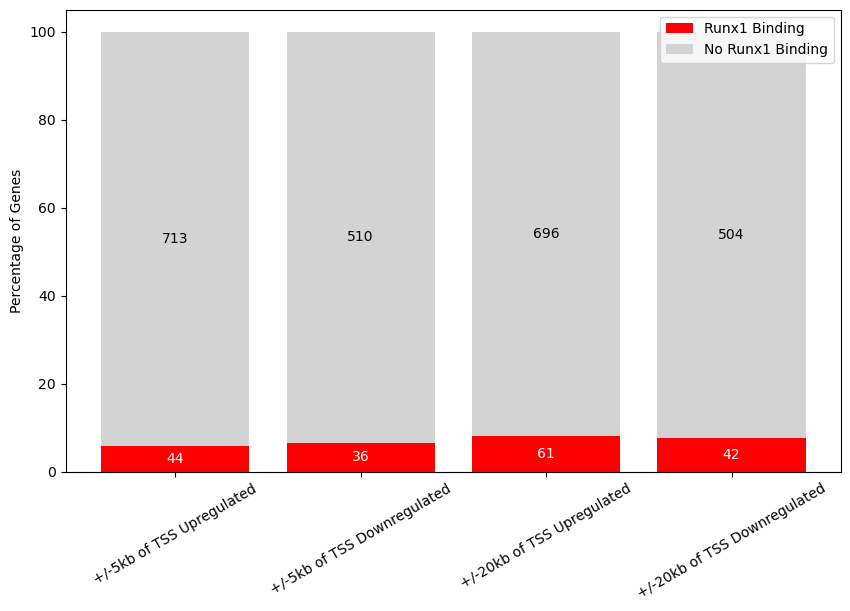

In [7]:
numUp = len(rnaseq_fltr[rnaseq_fltr['log2FoldChange'] > 1])
numDn = len(rnaseq_fltr[rnaseq_fltr['log2FoldChange'] < -1])

numUp5 = len(merged[merged['log2FoldChange'] > 1][abs(merged['dist']) < 5000])
numUp20 = len(merged[merged['log2FoldChange'] > 1][abs(merged['dist']) < 20000])
numDn5 = len(merged[merged['log2FoldChange'] < -1][abs(merged['dist']) < 5000])
numDn20 = len(merged[merged['log2FoldChange'] < -1][abs(merged['dist']) < 20000])

botVals = [numUp5, numDn5, numUp20, numDn20]
topVals = [x - y for x,y in zip([numUp, numDn, numUp, numDn], botVals)]
botPct = [x * 100 / y for x,y in zip(botVals, [numUp, numDn, numUp, numDn])]
topPct = [x * 100 / y for x,y in zip(topVals, [numUp, numDn, numUp, numDn])]

fig, ax = plt.subplots(figsize=(10, 6))
x = range(4)
bar1 = ax.bar(x, botPct, label='Runx1 Binding', color='red')
bar2 = ax.bar(x, topPct, bottom=botPct, label='No Runx1 Binding', color='lightgray')
ax.set_xticks(x)
ax.legend()

for i in range(4):
    # Label for "with ChIP"
    ax.text(x[i], botPct[i] / 2, str(botVals[i]),
            ha='center', va='center', color='white', fontsize=10)

    # Label for "without ChIP"
    ax.text(x[i], botPct[i] + topPct[i] / 2, str(topVals[i]),
            ha='center', va='center', color='black', fontsize=10)
ax.set_ylabel('Percentage of Genes')
ax.set_xticklabels(['+/-5kb of TSS Upregulated', '+/-5kb of TSS Downregulated',
                    '+/-20kb of TSS Upregulated', '+/-20kb of TSS Downregulated'],
                    rotation=30)

plt.show()



MALAT1 Tracks:
![alt text](MALAT1_tracks.png)
NEAT1 Tracks:
![alt text](NEAT1_tracks.png)

In [24]:
merged[merged['gene_name'] == 'MALAT1']

,gene_name,transcript,log2FoldChange,padj,id,chrom,start,end,strand,score,...,details,dist,promID,entrez,unigene,refseq,ensembl,alias,desc,type
661,MALAT1,NR_002819,-1.670245,2.547073e-13,rep2_peak_2992,chr11,65498956,65499159,+,205,...,lncRNA-promoter-TSS (ENST00000508832.3),1.0,ENST00000710857.1,ENSG00000251562,ENST00000710869,NaN,NaN,NaN,NaN,lncRNA
662,MALAT1,NR_002819,-1.670245,2.547073e-13,rep2_peak_2991,chr11,65497547,65497891,+,176,...,lncRNA-promoter-TSS (ENST00000534336.3),11.0,ENST00000710925.1,ENSG00000251562,ENST00000710869,NaN,NaN,NaN,NaN,lncRNA


In [23]:
merged[merged['gene_name'] == 'NEAT1']

,gene_name,transcript,log2FoldChange,padj,id,chrom,start,end,strand,score,...,details,dist,promID,entrez,unigene,refseq,ensembl,alias,desc,type
428,NEAT1,NR_028272,-1.950558,1.971059e-41,rep2_peak_2990,chr11,65422176,65422871,+,172,...,lncRNA-promoter-TSS (ENST00000499732.3),-251.0,ENST00000499732.3,ENSG00000245532,ENST00000645023,NaN,NaN,NaN,NaN,lncRNA


In [26]:
merged[merged['start'] > 65410000][merged['start'] < 65450000]

/scratch/ipykernel_3174670/954301348.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  merged[merged['start'] > 65410000][merged['start'] < 65450000]


,gene_name,transcript,log2FoldChange,padj,id,chrom,start,end,strand,score,...,details,dist,promID,entrez,unigene,refseq,ensembl,alias,desc,type
428,NEAT1,NR_028272,-1.950558,1.971059e-41,rep2_peak_2990,chr11,65422176,65422871,+,172,...,lncRNA-promoter-TSS (ENST00000499732.3),-251.0,ENST00000499732.3,ENSG00000245532,ENST00000645023,NaN,NaN,NaN,NaN,lncRNA


My data is in line with the figures from the paper, showing two close together peaks at the start of both genes (the refseq bars show multiple features but I confirmed these locations match up by coordinates). However, looking at the peak results, it look like while both peaks for MALAT1 are statistically significant, only one peak shows up for NEAT1. To be complete sure, especially because I'm not sure exactly how the results are labeled, I tried to look by start and end position to see if the peak was just associated with a different feature but there only seems to be one significant peak in the range shown by the track. 

In [14]:
samples = ["RUNX1 ChIP 1", "RUNX1 ChIP 2", "INPUT 1", "INPUT 2"]
total = []
mapped = []

for fname in ['IP_rep1_flagstat.txt', 'IP_rep2_flagstat.txt', 'INPUT_rep1_flagstat.txt', 'INPUT_rep2_flagstat.txt']:
    with open("results/" + fname) as f:
        txt = f.read()
        t = re.search(r"(\d+)\s+\+\s+0 in total", txt).group(1)
        m = re.search(r"(\d+)\s+\+\s+0 mapped", txt).group(1)
        total.append(t)
        mapped.append(m)

mapstats = pd.DataFrame({'Sample Name':samples, 
                         'Biological Replicate':[1,2,1,2],
                         'Raw Reads':total,
                         'Mapped Reads':mapped})

print(mapstats)

    Sample Name  Biological Replicate Raw Reads Mapped Reads
0  RUNX1 ChIP 1                     1  29050434     27983380
1  RUNX1 ChIP 2                     2  28968174     28363873
2       INPUT 1                     1  30041540     28533545
3       INPUT 2                     2  10890224      9994337


The total number of reads for my data is consistent (which should be trivial since the raw reads should be the same), but the mapped reads are quite a bit higher for my data, particularly for the input data (almost 10M for mapped reads for INPUT 1 and 2M more for INPUT 2, which is still proportionally a lot). I do see that they used hg19 while we used hg38, which may explain the difference. Since hg38 is generally speaking a better and more thorough human genome assembly, it makes sense that we would see higher alignment rates compared to hg19. 

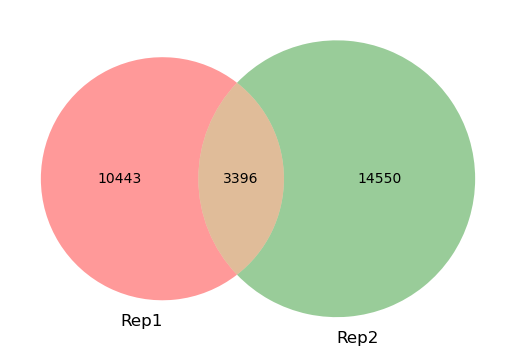

3060


In [17]:
rep1total = sum(1 for _ in open('results/rep1_peaks.narrowPeak'))
rep2total = sum(1 for _ in open('results/rep2_peaks.narrowPeak'))
combined = sum(1 for _ in open('results/consensus_peaks.bed'))

venn2(subsets=(rep1total-combined, rep2total-combined, combined), set_labels=('Rep1', 'Rep2'))
plt.show()
print(sum(1 for _ in open('results/filtered_peaks.bed')))

I think what happened here is that I was supposed to use the blacklist to filter before intersecting the peaks, but I instead intersected then filtered using the blacklist. I do think it's a good sign that there are more peaks for rep2 compared to rep1 and that the total number of filtered reproducible peaks I get (3060) is around what the paper found (3466). I'm also not sure if they set a different p-value threshold that got rid of some "noisy" peaks that I had. If so, it's possible that my initial peakcalling picked up many peaks that probably were removed in the intersection part because any noise would likely not be consistent between the two replicates. 